In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')
db_url = os.getenv('DB_URL')

In [113]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import adjust_pairplot_axes, wrap_labels, plot_xy_interactive

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
sql = """
SELECT
    report_date,
    sum(census_total) AS "Sheltered",
    sum(total_individuals_associated) AS "Sheltered by Associated Address"
FROM shelter_population
GROUP BY 1
"""
city_df = pd.read_sql(sql, con=db_url)
city_df["report_date"] = pd.to_datetime(city_df["report_date"])
print(city_df.shape)
city_df.head(3).T

(66, 3)


,0,1,2
report_date,2021-10-31 00:00:00,2018-03-31 00:00:00,2017-12-31 00:00:00
Sheltered,45910.0,NaN,NaN
Sheltered by Associated Address,42299,56373,56443


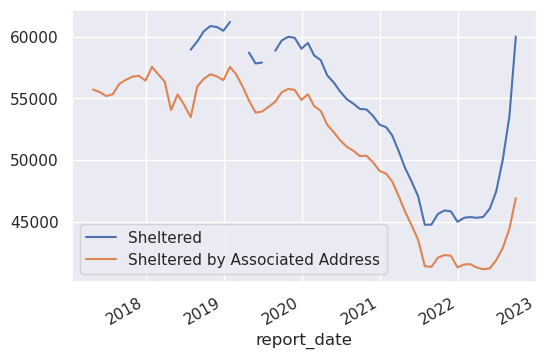

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
city_df.plot(kind='line', x='report_date', ax=ax)
fig.autofmt_xdate()

In [124]:
sql = """
SELECT
    report_date,
    borough_name,
    sum(census_total) AS "Sheltered in Borough",
    sum(census_total)::float / sum(sum(census_total)) over (partition by report_date) as "Fraction Sheltered in Borough",
    sum(total_individuals_associated) AS "Sheltered from Borough",
    sum(total_individuals_associated)::float / sum(sum(total_individuals_associated)) over (partition by report_date) as "Fraction Sheltered from Borough"
FROM shelter_population
GROUP BY 1, 2
"""
borough_df = pd.read_sql(sql, con=db_url)
borough_df["report_date"] = pd.to_datetime(borough_df["report_date"])
print(borough_df.shape)
borough_df.head(3).T

(330, 6)


,0,1,2
report_date,2017-04-30 00:00:00,2017-04-30 00:00:00,2017-04-30 00:00:00
borough_name,Staten Island,Bronx,Manhattan
Sheltered in Borough,NaN,NaN,NaN
Fraction Sheltered in Borough,NaN,NaN,NaN
Sheltered from Borough,1245,20737,9283
Fraction Sheltered from Borough,0.022345,0.372178,0.166607


''

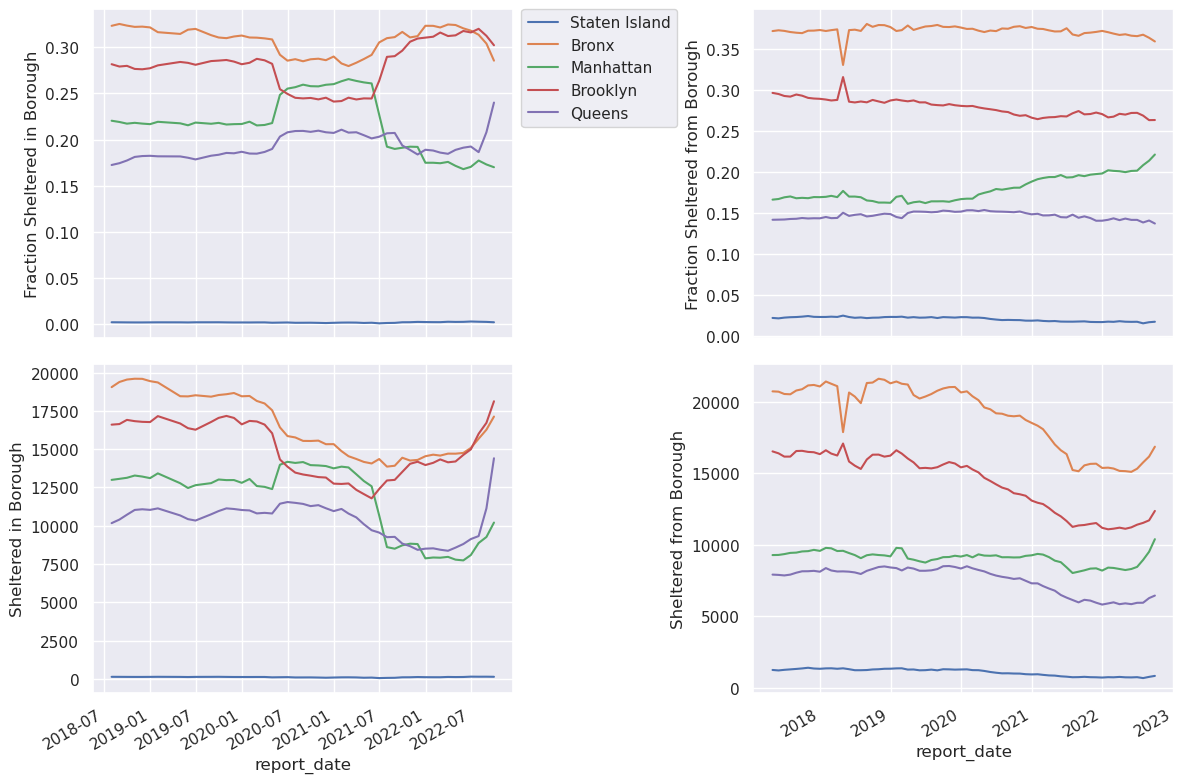

In [125]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 8))
seaborn.lineplot(
    borough_df,
    x='report_date',
    y='Fraction Sheltered in Borough',
    hue='borough_name',
    ax=ax11
)
ax11.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
seaborn.lineplot(
    borough_df,
    x='report_date',
    y='Fraction Sheltered from Borough',
    hue='borough_name',
    ax=ax12,
    legend=None
)
seaborn.lineplot(
    borough_df,
    x='report_date',
    y='Sheltered in Borough',
    hue='borough_name',
    ax=ax21,
    legend=None
)
seaborn.lineplot(
    borough_df,
    x='report_date',
    y='Sheltered from Borough',
    hue='borough_name',
    ax=ax22,
    legend=None
)
fig.autofmt_xdate()
plt.tight_layout()
;

In [188]:
sql = """
SELECT
    report_date,
    _is_most_recent_report,
    shelter_population.borough_name,
    borough_district_code,
    COALESCE(districts.district_name, 'Unknown') AS district_name,
    census_total AS "Sheltered in District",
    census_total::float / sum(census_total) over (partition by report_date) as "Fraction Sheltered in District",
    total_individuals_associated AS "Sheltered from District",
    total_individuals_associated::float / sum(total_individuals_associated) over (partition by report_date) as "Fraction Sheltered from District",
    population_2020 AS "Population",
    population_2020::float / sum(population_2020) over (partition by report_date) AS "Fraction of Population",
    adult_shelter AS "Adult-only Sheltered",
    adult_shelter::float / sum(adult_shelter) over (partition by report_date) AS "Fraction of Adult-only Sheltered",
    adult_shelter::float / nullif(census_total, 0) AS "Adult-only Fraction of Sheltered"
FROM shelter_population
    LEFT JOIN districts USING (borough_district_code)
ORDER BY census_total DESC
"""
district_df = pd.read_sql(sql, con=db_url)
district_df["report_date"] = pd.to_datetime(district_df["report_date"])
print(district_df.shape)
district_df.head(3).T

(4223, 14)


,0,1,2
report_date,2021-08-31 00:00:00,2017-04-30 00:00:00,2017-04-30 00:00:00
_is_most_recent_report,False,False,False
borough_name,Manhattan,Bronx,Bronx
borough_district_code,NaN,202.0,203.0
district_name,Unknown,"Hunts Point, Morrisania","Morrisania, Concourse Village"
Sheltered in District,NaN,NaN,NaN
Fraction Sheltered in District,NaN,NaN,NaN
Sheltered from District,3127,1037,1889
Fraction Sheltered from District,0.075645,0.018612,0.033903
Population,NaN,54454.0,93755.0


''

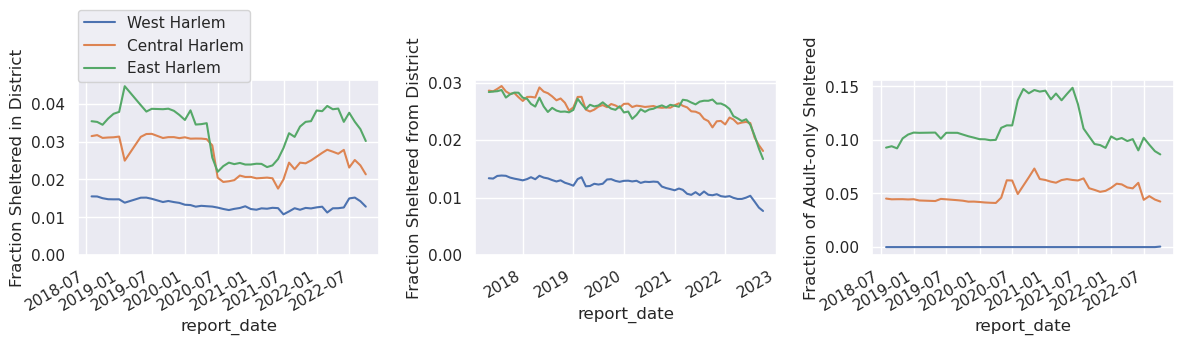

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
harlem_districts = district_df[district_df['borough_district_code'].isin((109, 110, 111))]
seaborn.lineplot(
    harlem_districts,
    x='report_date',
    y='Fraction Sheltered in District',
    hue='district_name',
    ax=ax1
)
ax1.set_ylim((0, ax1.get_ylim()[1]))
ax1.legend(bbox_to_anchor=(0, 1.4), loc='upper left', borderaxespad=0)
seaborn.lineplot(
    harlem_districts,
    x='report_date',
    y='Fraction Sheltered from District',
    hue='district_name',
    ax=ax2,
    legend=None
)
ax2.set_ylim((0, ax2.get_ylim()[1]))
seaborn.lineplot(
    harlem_districts,
    x='report_date',
    y='Fraction of Adult-only Sheltered',
    hue='district_name',
    ax=ax3,
    legend=None
)
# ax3.set_ylim((0, ax3.get_ylim()[1]))
fig.autofmt_xdate()
plt.tight_layout()
;

In [190]:
harlem_districts[harlem_districts._is_most_recent_report]
# Generally districts have the same fraction of sheltered as they do fraction of sheltered *from* the district
# Sheltered vs Population?
# What about unknowns?
# But, by districts, what is the fraction of adults vs not

,report_date,_is_most_recent_report,borough_name,borough_district_code,district_name,Sheltered in District,Fraction Sheltered in District,Sheltered from District,Fraction Sheltered from District,Population,Fraction of Population,Adult-only Sheltered,Fraction of Adult-only Sheltered,Adult-only Fraction of Sheltered
1783,2022-09-30,True,Manhattan,111.0,East Harlem,1808.0,0.030129,784,0.016713,125771.0,0.014287,1231.0,0.086410,0.680863
2056,2022-09-30,True,Manhattan,110.0,Central Harlem,1280.0,0.021330,850,0.018120,130440.0,0.014817,605.0,0.042468,0.472656
2784,2022-09-30,True,Manhattan,109.0,West Harlem,768.0,0.012798,360,0.007674,110458.0,0.012547,7.0,0.000491,0.009115


In [191]:
# For comparing shelter population in district to population from district, spread the unknowns
# throughout their borough in proportion to the shelter population already from there.
current_district_df = district_df[district_df._is_most_recent_report 
    & ~district_df.borough_district_code.isnull()]
unknown_districts = district_df[district_df._is_most_recent_report 
    & district_df.borough_district_code.isnull()]
unknown_district_sheltered = dict(unknown_districts[['borough_name', 'Sheltered from District']].values)

current_district_df['Sheltered from District (Estimate)'] = (
    current_district_df['Sheltered from District']
        .groupby(current_district_df['borough_name'])
        .transform(lambda g: g + (g / g.sum()) * unknown_district_sheltered[g.name])
)
current_district_df['Fraction Sheltered from District (Estimate)'] = (
    current_district_df['Sheltered from District (Estimate)'] 
    / current_district_df['Sheltered from District (Estimate)'].sum()
)
current_district_df.head(3).T

/tmp/ipykernel_8309/1419387916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_district_df['Sheltered from District (Estimate)'] = (
/tmp/ipykernel_8309/1419387916.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_district_df['Fraction Sheltered from District (Estimate)'] = (


,1425,1429,1532
report_date,2022-09-30 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00
_is_most_recent_report,True,True,True
borough_name,Brooklyn,Queens,Bronx
borough_district_code,316.0,412.0,204.0
district_name,Brownsville,"Jamaica, South Jamaica","Highbridge, Concourse"
Sheltered in District,3700.0,3688.0,2783.0
Fraction Sheltered in District,0.061658,0.061458,0.046377
Sheltered from District,1038,998,1354
Fraction Sheltered from District,0.022127,0.021275,0.028864
Population,98506.0,256278.0,150436.0


In [182]:

plot_xy_interactive(
    current_district_df,
    x_col = 'Fraction Sheltered in District',
    y_col = 'Fraction Sheltered from District (Estimate)',
    color_col='borough_name',
    tooltip=['district_name'] + [c for c in current_district_df.columns if 'Sheltered' in c]
)

# Nothing really stands out here.
# Generally linear, though noisy, once we spread the unknowns around.
# Before it was sublinear--probably just clustering around the line of the "fraction of knowns"

/home/skritch/miniconda3/envs/harlem/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [185]:

plot_xy_interactive(
    current_district_df,
    x_col = 'Fraction Sheltered in District',
    y_col = 'Fraction of Population',
    color_col='borough_name',
    tooltip=['district_name'] + [c for c in current_district_df.columns if 'Sheltered' in c]
)

# Nothing really stands out here.
# Generally linear, though noisy, once we spread the unknowns around.
# Before it was sublinear--probably just clustering around the line of the "fraction of knowns"

/home/skritch/miniconda3/envs/harlem/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [194]:
# dataset for a map view of either a) shelter population, adult shelter population, or fraction-adult-only.
(current_district_df
    .sort_values('Adult-only Sheltered', ascending=False)
    .head(10)
)

,report_date,_is_most_recent_report,borough_name,borough_district_code,district_name,Sheltered in District,Fraction Sheltered in District,Sheltered from District,Fraction Sheltered from District,Population,Fraction of Population,Adult-only Sheltered,Fraction of Adult-only Sheltered,Adult-only Fraction of Sheltered,Sheltered from District (Estimate),Fraction Sheltered from District (Estimate)
1783,2022-09-30,True,Manhattan,111.0,East Harlem,1808.0,0.030129,784,0.016713,125771.0,0.014287,1231.0,0.086410,0.680863,1899.249592,0.040487
1930,2022-09-30,True,Brooklyn,301.0,"Williamsburg, Greenpoint",1521.0,0.025347,291,0.006203,204125.0,0.023188,1069.0,0.075039,0.702827,439.502014,0.009369
2225,2022-09-30,True,Manhattan,106.0,"Stuyvesant town, Murray Hill",1143.0,0.019047,116,0.002473,155614.0,0.017677,913.0,0.064088,0.798775,281.011419,0.005990
1870,2022-09-30,True,Brooklyn,305.0,East New York,1600.0,0.026663,1348,0.028736,200293.0,0.022752,822.0,0.057700,0.513750,2035.906239,0.043400
1683,2022-09-30,True,Bronx,203.0,"Morrisania, Concourse Village",2114.0,0.035229,1242,0.026476,93755.0,0.010650,681.0,0.047803,0.322138,1954.860476,0.041673
1645,2022-09-30,True,Bronx,205.0,"Fordham, University Heights",2233.0,0.037212,1117,0.023812,132584.0,0.015061,669.0,0.046961,0.299597,1758.115259,0.037478
1425,2022-09-30,True,Brooklyn,316.0,Brownsville,3700.0,0.061658,1038,0.022127,98506.0,0.011190,626.0,0.043942,0.169189,1567.708216,0.033419
2056,2022-09-30,True,Manhattan,110.0,Central Harlem,1280.0,0.021330,850,0.018120,130440.0,0.014817,605.0,0.042468,0.472656,2059.135400,0.043895
2281,2022-09-30,True,Bronx,207.0,"Norwood, Kingsbridge Heights",1085.0,0.018081,764,0.016287,146813.0,0.016677,604.0,0.042398,0.556682,1202.506766,0.025634
1845,2022-09-30,True,Brooklyn,303.0,Bedford-Stuyvesant,1648.0,0.027463,997,0.021253,174960.0,0.019875,564.0,0.039590,0.342233,1505.785252,0.032099
